# State-space estimation for drone IMU data

## Import libraries and load in data

In [18]:
# Import core data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import state-space libraries
from scipy.fft import rfft, rfftfreq
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from filterpy.kalman import KalmanFilter

In [27]:
import matplotlib.pyplot as plt

# Chart theme
plt.rcParams.update({

    # Backgrounds
    "figure.facecolor": "#0B0F10",   # deep matte black-blue
    "axes.facecolor":   "#0B0F10",

    # Text & labels
    "text.color":       "#D0D6D8",
    "axes.labelcolor":  "#D0D6D8",
    "xtick.color":      "#A8B2B5",
    "ytick.color":      "#A8B2B5",

    # Lines & markers (radar green)
    "axes.prop_cycle": plt.cycler(color=["#4EFF8E", "#4EC9FF", "#FFDD4E", "#FF4E4E"]),

    # Grid (subtle tactical overlay)
    "axes.grid": True,
    "grid.color": "#2A3236",
    "grid.linestyle": "--",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.6,

    # Spines
    "axes.edgecolor": "#3A4144",
    "axes.linewidth": 1.2,

    # Titles & fonts
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "font.size": 12,
    "font.family": "DejaVu Sans",

    # Legend
    "legend.facecolor": "#0E1315",
    "legend.edgecolor": "#2A3236",
    "legend.framealpha": 0.8,
    "legend.fontsize": 10,

    # Saving
    "savefig.facecolor": "#0B0F10",
    "savefig.edgecolor": "#0B0F10",
})


In [19]:
df = pd.read_csv('../data/drone_imu.csv')

In [22]:
# Rename columns

rename_map = {
    "#timestamp [ns]": "timestamp_ns",
    "w_RS_S_x [rad s^-1]": "gyro_x",
    "w_RS_S_y [rad s^-1]": "gyro_y",
    "w_RS_S_z [rad s^-1]": "gyro_z",
    "a_RS_S_x [m s^-2]": "accel_x",
    "a_RS_S_y [m s^-2]": "accel_y",
    "a_RS_S_z [m s^-2]": "accel_z"
    }

df = df.rename(columns=rename_map)

In [23]:
df

,timestamp_ns,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z
0,1403715273262142976,-0.002094,0.017453,0.077493,9.087496,0.130755,-3.693838
1,1403715273267142912,-0.001396,0.019548,0.078191,9.079323,0.122583,-3.693838
2,1403715273272143104,-0.002094,0.016755,0.074700,9.038462,0.147100,-3.669322
3,1403715273277143040,-0.002793,0.020944,0.078191,9.071151,0.122583,-3.677494
4,1403715273282142976,-0.002094,0.020944,0.078889,9.079323,0.130755,-3.702010
...,...,...,...,...,...,...,...
29115,1403715418837143040,-0.003491,0.019548,0.073304,9.169218,0.310544,-3.219850
29116,1403715418842142976,-0.008378,0.019548,0.070511,9.357179,0.204305,-3.326089
29117,1403715418847142912,-0.003491,0.023038,0.074002,9.161046,0.269683,-3.260711
29118,1403715418852143104,-0.002094,0.017453,0.073304,9.283629,0.286027,-3.326089


## 1. EDA

In [24]:
df.columns

Index(['timestamp_ns', 'gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y',
       'accel_z'],
      dtype='object')

In [25]:
# Convert nanoseconds to seconds in relative time since start
df['time_sec'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) * 1e-9

# Group sensor variables
sensor_cols = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']
df = df[['time_sec'] + sensor_cols]

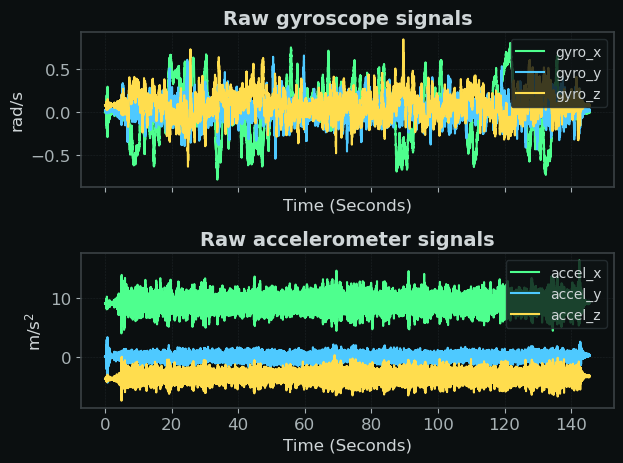

In [40]:
# Plot sensor data

fig, axes = plt.subplots(2, 1, sharex=True)

# Gyro sensors
for c in sensor_cols[:3]:
    axes[0].plot(df['time_sec'], df[c], label=c)
axes[0].set_title('Raw gyroscope signals')
axes[0].set_ylabel('rad/s')
axes[0].set_xlabel('Time (Seconds)')
axes[0].legend(loc='upper right')

# Acceleration sensors
for c in sensor_cols[3:]:
    axes[1].plot(df['time_sec'], df[c], label=c)
axes[1].set_title('Raw accelerometer signals')
axes[1].set_xlabel('Time (Seconds)')
axes[1].set_ylabel('m/s$^{2}$')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [49]:
# Compute sample variance and differenced variance
print(f'Sample Variance\n{df[sensor_cols].var()}')
print(f'\nDifferenced sample Variance\n{df[sensor_cols].diff().dropna().var()}')

Sample Variance
gyro_x     0.071238
gyro_y     0.012861
gyro_z     0.022779
accel_x    1.296645
accel_y    0.270197
accel_z    0.722386
dtype: float64

Differenced sample Variance
gyro_x     0.000526
gyro_y     0.006056
gyro_z     0.001567
accel_x    3.903093
accel_y    0.645817
accel_z    2.509868
dtype: float64


accel_x and accel_z seem to be the noisiest sensors

A divergence in the variances normally means that even though a sensor can appear noisy(large R), the latent state is actually stable(small Q)
By comparing the variance and diff-variance we can distinguish between axes(sensor x,y,z) dominated by noise and axes where the latent state actually evolves over time, letting us separate sensor jitters from actual motion in the system

The variance for gyros is pretty small --> small R, diff-variance for gyros are also tame --> small Q
the variance for accelerometers is higher --> med-large R, diff-variance for accelerometer are very high --> large Q

we use a 6-D state that corresponds to the IMU channels:

xt = [wx(t), wy(t), wz(t), ax(t), ay(t), az(t)] - Latent true state of the system (what we estimate using the kalman filter)
xt = Fxt-1 + wt : The state evolves smoothly, with wt ~ N(0,Q)

Differenced variance captures the volatility of the measurements or rapid changes, if the difference variance is big
Q matrix should be larger, if small we should lower Q. (Q: Allows changes in the latent state without letting it wander too freely)
F(Transition matrix) = I6: a random walk transition, small process noise, no interactions between variables
Noise covariance structure for Q: Q = σQ^2(I6) - Q increased --> more drift allowed

===========================================================================================================================

zt = [x1, x2, x3, x4, x5, x6] - The noisy measurment we observe (data)
zt = Hxt-1 + vt : measurement = state + noise, with vt ~ N(0,R)

Raw variance captures the noise level in the measurements which we can adjust R matrix
in our model to smooth correctly a larger raw var means we raise R, the opposite is also true
smaller raw variance means we should lower R. (R: diagnoal matrix based on variances of each IMU variable)
H(Observation matrix) = I6: each observation directly measures the corresponding state
Noise covariance structure for R: R = diag(r1, r2, r3, r4, r5, r6) - R increased --> more smoothing

===========================================================================================================================

The Kalman filter uses the noise levels in Q and R to estimate what the true motion likely was.

We are assuming that the IMU signals change slowly over time and follow a random walk: xt = xt-1 + wt

## 2. Building the state-space model

In [56]:
# Define F, H, Q, R

dim_x = 6 # Corresponds to the 6 variables (state dimension)
dim_z = 6 # Corresponds to the 6 variables (measurement dimension)

# State transition and Observation matricies: Identity matrix for both of these
F = np.eye(dim_x)
H = np.eye(dim_z) # F is a random walk, drift regulated by Q, H has each sensor exactly measure corresponding state

# Extract per axis noise levels - which become diagonal entries of R
meas_var = df[sensor_cols].var().values

# Build measurement noise covariance R
c_R = 1.0
R = np.diag(c_R * meas_var)

# Build process noise covariance Q and adjust the scaler for Q
q_scale = 0.01
Q = q_scale * np.diag(meas_var)

print(f'F:\n{F}')
print(f'H:\n{H}')
print(f'Q:\n{Q}')
print(f'R:\n{R}')

F:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
H:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Q:
[[0.00071238 0.         0.         0.         0.         0.        ]
 [0.         0.00012861 0.         0.         0.         0.        ]
 [0.         0.         0.00022779 0.         0.         0.        ]
 [0.         0.         0.         0.01296645 0.         0.        ]
 [0.         0.         0.         0.         0.00270197 0.        ]
 [0.         0.         0.         0.         0.         0.00722386]]
R:
[[0.07123816 0.         0.         0.         0.         0.        ]
 [0.         0.01286056 0.         0.         0.         0.        ]
 [0.         0.         0.02277912 0.         0.         0.        ]
 [0.         0.         0.         1.29664487 0.         0.        ]
 [0.         0.         0.         0.      

### Matricies and their functions
F keeps latent state smooth\
Q lets the state drift\
H ties each observation to its corresponding state\
R weights the measurements according to their variances

### The Kalman Filter
The Kalman filter algorithm runs in two phases at each time step:

Predict
- using the state model to predict the next state before seeing the measurement
- produces the prior state estimate (xhat(t|t-1)) and its covariance

Update 
- compares predicted measurement (Hxhat(t|t-1)) to observed measurement zt
- the difference between the predicted measurement and observed measurement is the innovation or measurement residual.\
We use innovation to calculate kalman gain - which balances the trust between model and measurement.
- updates the state estimate to xhat(t|t)

### Formulas
- **Predicted state**: $\hat{x}_{t\mid t-1}$

- **Predicted covariance**: $P_{t\mid t-1}$

- **Filtered (updated) state**: $\hat{x}_{t\mid t}$

- **Filtered covariance**: $P_{t\mid t}$

- **Observed measurement**: $z_t$

- **Innovation (measurement residual)**: $y_t = z_t - H \hat{x}_{t\mid t-1}$

**Predict step:**

$\hat{x}_{t \mid t-1} = F \, \hat{x}_{t-1 \mid t-1}$

$P_{t \mid t-1} = F \, P_{t-1 \mid t-1} \, F^\top + Q$


**Innovation:**

$y_t = z_t - H \, \hat{x}_{t \mid t-1}$

$S_t = H \, P_{t \mid t-1} \, H^\top + R$


**Kalman gain:**

$K_t = P_{t \mid t-1} \, H^\top \, S_t^{-1}$


**Update step:**

$\hat{x}_{t \mid t} = \hat{x}_{t \mid t-1} + K_t \, y_t$

$P_{t \mid t} = (I - K_t H) \, P_{t \mid t-1}$

In [ ]:
# Implement Kalman filter

kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)

kf.F = F
kf.H = H
kf.Q = Q
kf.R = R

# Initial state - using first observation

z0 = df[sensor_cols].iloc[0].values
kf.x = z0.reshape(-1, 1) # conver state vector into a column vector